In [1]:
# Real life data

import logging
import json
import threading
import itertools
import pandas as pd  
import numpy as np  
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore)
from mmfunctions.telemanom import (TelemanomConfig, TelemanomModel, TelemanomEstimator, LSTMRegressor)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
import skimage as ski

from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

/home/markus/.local/lib/python3.8/site-packages/iotfunctions/bif.py:1873: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'
Using TensorFlow backend.


In [3]:
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())


db_schema=None           
fm = FileModelStore()
db = Database(credentials=credentials) # , model_store=fm)
print (db)

2020-06-30T16:09:56.108 INFO iotfunctions.dbtables.__init__ Init FileModelStore


In [33]:
df_input = pd.read_csv('iot_vacuum_rawHouseAir.csv', parse_dates=['rcv_timestamp_utc'])
df_input2 = pd.read_csv('dm_vacuum_KMeanScore.csv', parse_dates=['timestamp'])
df_input['timestamp'] = df_input['rcv_timestamp_utc']
df_input['score'] = df_input2['value_n']
df_input = df_input.dropna()
df_input = df_input.set_index(['timestamp'])
df_input = df_input[['houseair','score']]
df_input
df_snippet = df_input.head(50)

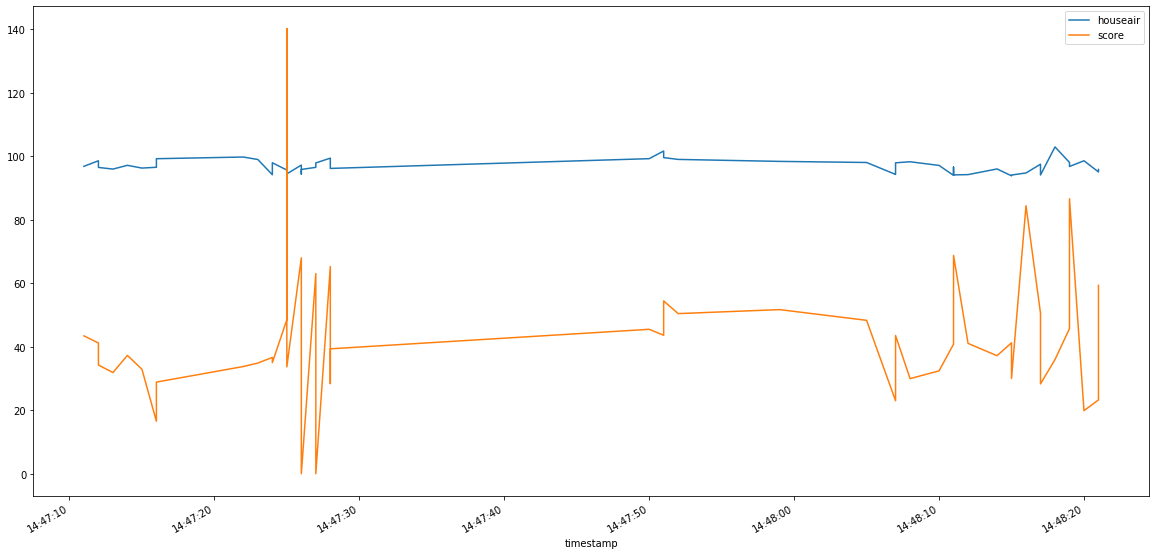

In [34]:
df_snippet.plot(figsize=(20,10))

In [5]:
# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.DEBUG)

# !!!!!
# COPY feature to target - we're predicting future data points of the same column
# !!!!!
df_input['Vx_copy'] = df_input['Vx']

aweii = bif.AggregateWithExpression(input_items=['Vx'], output_items=['VxA'], expression='{0}.max()')

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = aweii._build_entity_type(columns = [Column('Vx',Float()), Column('speed',Float()),
                                        Column('Vy',Float())], **jobsettings)

# 'granularity': ('H', (), True),
print (et)

aweii._entity_type = et


df_input = aweii.execute(df=df_input)

2020-04-08T17:28:59.601 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-04-08T17:28:59.603 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-04-08T17:28:59.604 DEBUG iotfunctions.util.__init__ Starting trace
2020-04-08T17:28:59.605 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_AggregateWithExpression_20200408152859
2020-04-08T17:28:59.605 DEBUG iotfunctions.util.__init__ auto_save None
2020-04-08T17:28:59.606 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-04-08T17:28:59.607 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-04-08T17:28:59.607 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_AGGREGATEWITHEXPRESSION
Functions:
Granularities:
No schedules metadata

LocalEntityType

In [25]:
df_input

,entity,timestamp,Vx,Vy,Vz,Ap,As,speed,Vx_copy
0,04714B6046D5,2020-01-01 00:02:25.928,-0.0439,-0.0137,-1.0029,2.2904,1.036,1.036,-0.0439
1,04714B6046D5,2020-01-01 00:03:25.928,-0.0430,-0.0205,-0.9023,2.2904,1.036,1.036,-0.0430
2,04714B6046D5,2020-01-01 00:04:25.928,0.0039,-0.0371,-1.0596,2.2904,1.036,1.036,0.0039
3,04714B6046D5,2020-01-01 00:05:25.928,0.0283,0.0137,-0.9629,2.2824,1.036,1.036,0.0283
4,04714B6046D5,2020-01-01 00:06:25.928,-0.0771,-0.0068,-0.9541,2.2824,1.036,1.036,-0.0771
...,...,...,...,...,...,...,...,...,...
129295,04714B6046D5,2020-01-31 12:09:23.501,0.0293,-0.0459,-0.9678,2.2760,1.037,1.037,0.0293
129296,04714B6046D5,2020-01-31 12:10:23.501,-0.0879,-0.0322,-0.8750,2.2760,1.037,1.037,-0.0879
129297,04714B6046D5,2020-01-31 12:11:23.501,0.0596,-0.0166,-0.9795,2.2744,1.037,1.037,0.0596
129298,04714B6046D5,2020-01-31 12:12:23.501,0.0801,-0.0215,-1.0166,2.2744,1.037,1.037,0.0801
